# Weightloss ANOVA


## 1: Implement subroutine generating random data

In [1]:
import numpy as np
import numpy.random as npr
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

# import statsmodels.api as sm
# from statsmodels.formula.api import ols

from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

from itertools import chain

In [2]:
df = pd.read_excel("data/blood_plasma_data.xlsx", skiprows=list(range(6)) + list(range(15,18)),parse_cols=[0]+list(range(3,318)), header=0, index_col=0)

# print(df.head())
parsed_df = df.copy()

In [3]:
patients = [raw.split('_')[1] for raw in df.columns]
timepoints = [raw.split('_')[2] for raw in df.columns]

print(patients[:10])
print(timepoints[:10])

# df1.assign(e=p.Series(np.random.randn(sLength)).values)
# df.assign(patient=patients)

['02', '02', '02', '02', '02', '02', '02', '03', '03', '03']
['1', '2', '3', '4', '5', '6', '7', '1', '2', '3']


In [4]:
parsed_df_nona = df.dropna(inplace=False)
parsed_df_nona.head()

,_02_1,_02_2,_02_3,_02_4,_02_5,_02_6,_02_7,_03_1,_03_2,_03_3,...,_57_2,_57_3,_57_4,_57_5,_57_6,_57_7,_58_1,_58_2,_58_3,_58_4
Participant_Timepoint,,,,,,,,,,,,,,,,,,,,,
A0A075B6H9,8.918735,8.984415,8.960561,8.932846,8.888815,8.682663,9.100348,8.534421,8.627316,8.763565,...,9.108068,9.125790,9.154156,8.903898,8.931898,9.024222,8.740736,8.659849,8.556024,8.850599
A0A075B6I1,8.431114,8.309657,8.135550,8.288545,8.206241,8.232878,8.552498,8.054749,8.046690,8.136787,...,8.595130,8.681826,8.663883,8.702065,8.702471,8.613501,8.241886,8.195170,8.134278,8.135195
A0A075B6I2,7.966115,8.009408,7.850430,7.928467,7.854250,7.915487,7.681106,8.035768,8.083920,8.258530,...,7.894744,7.704866,7.552169,7.719073,7.612115,7.661106,8.335114,8.194396,8.121626,8.198227
A0A075B6I9,9.140631,9.235167,9.361082,9.207253,9.399657,9.467562,9.438647,9.003380,9.186728,9.012941,...,9.167032,9.160809,9.088869,9.146871,9.176959,9.069520,9.277361,9.157724,8.995350,9.274189
A0A075B6J4,9.184549,9.280607,9.195454,9.285729,9.236535,9.260201,9.624893,8.971605,9.068478,9.028275,...,9.258528,9.262970,9.165575,9.206120,9.323686,9.261523,9.373257,9.416043,9.127040,9.312214


# Generate dW matrix

In [5]:
import sys

def get_dw_row(row):

    row_vals = list()
    for patient in set(patients):

        patient_index = np.array(patients) == patient
        patient_vals = list(row[patient_index])

        base_weight = patient_vals[0]

        dw_vals = list()
        for weight in patient_vals:
            num_weight = float(weight)
            dw = num_weight - base_weight        
            dw_vals.append(dw)
        row_vals.extend(dw_vals)
    return row_vals

# print(row.head())    
# print("Row length: {}".format(len(row)))
# print("Tot patients: {}".format(tot_patients))
# print("Patient vals: {}".format(patient_vals))
# print(len(row_vals))
# print(row_vals)

In [6]:
# weight_df = parsed_df_nona.apply(get_dw_row, axis=1)
weights = parsed_df.loc["Weight", :]
dw_weights = get_dw_row(weights)
print(dw_weights[:10])

[0.0, -15.200000000000003, -17.200000000000003, -23.200000000000003, -30.900000000000006, -31.400000000000006, -34.400000000000006, 0.0, -12.900000000000006, -15.400000000000006]


## 3: Calculate p-values

`ttest_rel`: t-test on two related samples of scores. Participants in the two groups are related. For instance - if participants in first group are same as the one in the second group. This is also called **repeated measures design**.

`ttest_ind`: Independent. Compare groups of participants that are not related in any way. Participants in one group have no relationship to participants in second group.

In [7]:
def get_anova_p_from_row(row, patients, timepoints, dw_weights):

    row_df = pd.DataFrame({"patient":patients,
                           "timepoint":timepoints,
                           "value":row,
                           "dw":dw_weights})
#     print(row_df)
    row_fit = ols('value ~ C(patient) + dw', data=row_df).fit()
    report = anova_lm(row_fit, type=2)
    anova_p = report.loc["dw", "PR(>F)"]
    return anova_p


In [8]:
row = parsed_df.iloc[1,:]
get_anova_p_from_row(row, patients, timepoints, dw_weights)

/usr/local/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/usr/local/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/usr/local/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


0.44349149833896029

In [9]:
anova_p = parsed_df_nona.apply(get_anova_p_from_row, axis=1, patients=patients, timepoints=timepoints, dw_weights=dw_weights)
# print(anova_p)
pvals = list(anova_p)
print(pvals[:10])
# anova_p[:10]

/usr/local/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/usr/local/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/usr/local/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


[0.78075782311526087, 0.68467159839228908, 0.18396897329700548, 0.39639244080197233, 0.41300738304796125, 0.058124803492377156, 0.61924905950288123, 0.68145627021272737, 0.85367808112964538, 0.80876818285144614]


## 4: Implement subroutine for calculating q-value

* Let p_1 <= p_2 <= p_m be ordered p-values
* For a range lambda, say lambda = 0, 0.01, 0.02.., 0.95 calculate: pi0(lambda) = # {p_j > lambda} / m(1-lambda)
* Let f be the natural cubic spline (in our case - average for high p-values)
* Set estimate of pi_0 to be: pi_0 = f(1)
* Calculate q(p(m)) = min((pi_0*m*t)/#{p_i <= t}) = pi_0 * p(m)
* For i = m - 1, m - 2, ..., 1 calculate:
* The estimated q is the ith most significant feaure is q(p(i))

In [10]:
def estimate_pis(pvals):
    
    pi_0_vals = list()
    
    for sub_thres in np.arange(0.01, 0.96, 0.01):
        sub_p = [p for p in pvals if p > sub_thres]
        sub_p_count = len(sub_p)
        m = len(pvals)
        pi_0 = sub_p_count / (m * (1-sub_thres))
        pi_0_vals.append(pi_0)
  
    return pi_0_vals

def estimate_pi_zero(pis, thres):
    
    tot = len(pis)
    start_ind = int(tot * thres)
    sub = pis[start_ind:]
    return np.mean(sub)


### Diff test

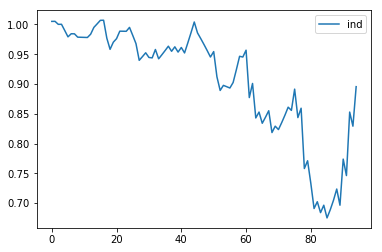

In [11]:
pi_0_vals = estimate_pis(pvals)
plt.plot(pi_0_vals, label="ind")
# plt.plot(rel_pi_0_vals, label="rel")
plt.legend()
plt.show()

#### q-value calculations

In [12]:
def estimate_q_vals(pvals):
    pi_estimates = estimate_pis(pvals)
    pi_0 = estimate_pi_zero(pi_estimates, 0.75)
    m = len(pvals)
    
    fdr_vals = list()
    for t in sorted(pvals):
        val = pi_0 * m * t / (len(fdr_vals) + 1)
        fdr_vals.append(val)

    q_vals = list()
    for sub_i in range(1, len(fdr_vals)):
        fdr_slice = fdr_vals[len(fdr_vals) - sub_i:]
        q = min(fdr_slice)
        q_vals.insert(0, q)

    print("pi_0: {}".format(pi_0))
    print("m: {}".format(len(pvals)))
    return q_vals


In [13]:
qvals = estimate_q_vals(pvals)
# rel_q_vals = estimate_q_vals(rel_p_vals)


pi_0: 0.7757102313325497
m: 201


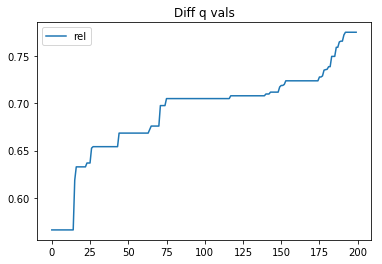

In [14]:
# plt.plot(ind_q_vals, label="ind")
# x_vals = [x / len(qvals) for x in range(len(qvals))]
plt.plot(qvals, label="rel")
plt.legend()
plt.title("Diff q vals")
plt.show()

## 5: Differential expression genes, on q-threshold

In [15]:
xvals = np.arange(0, 0.5, 0.005)

In [16]:
counts = list()
for thres in xvals:
    count = len([q for q in qvals if q <= thres])
    counts.append(count)


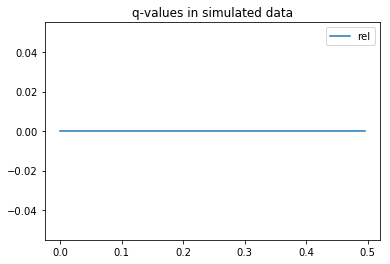

In [17]:
# plt.plot(xvals, ind_counts, label="ind")
plt.plot(xvals, counts, label="rel")
plt.title('q-values in simulated data')
plt.legend()
plt.show()

# 6: Differential expression results

In [18]:
print("Total values: {}".format(len(qvals)))
print("Significant independent: {}".format(len([q for q in qvals if q <= 0.1])))
# print("Significant dependent: {}".format(len([q for q in rel_q_vals if q <= 0.01])))

Total values: 200
Significant independent: 0
